# Teaching Model Predictive Control with a Stirred Reactor Example

In this study we implement a model predictive control (MPC) for a dummy chemical reactor. This notebook guides you through the different steps of the implementation using the powerful package [CasADi](https://web.casadi.org/) in its Python programming interface. Our goal is to provide controlled concentration output, which may be required to change in time, *i.e.* a costumer order required different concentratio, in a continuous stirred tank reactor. In our dummy production, reagent $A$ is fed to the system with a carrier $B$ to produce $C$, whose concentration is the target. The chemical process is illustrated as the irreversible reaction happening at a known rate $k_1$:

$$
A + B \rightarrow B + C
$$

To control the molar fraction of $C$, denoted $x_C$, we play with flow rates of $A$ and $B$ given by $\dot{q}_A$ and $\dot{q}_B$. For smooth functioning of the system, the total flow rate is required to remain constant at $\dot{q}_t$ so that $\dot{q}_B=\dot{q}_t-\dot{q}_A$, *i.e.* a compensation valve is the action we control. That implies we have a single degree of freedom in the actions we can take to pilot this simple system.

The reactor volume is kept constant at $n_t$ moles. The following differential equation applies to each chemical species $i$

$$
n_t\dot{x}_i = \dot{q}_i - \dot{q}_t x_i + \dot{n}_{gen,i}
$$

Here $\dot{n}_{gen,B}$ is zero for $B$ and is computed as a first order kinetic term $\dot{n}_{gen,A}=-\dot{n}_{gen,C}=-k_1 x_A$ for other species.

To create the optimization routine we will make use of `SX` symbolic class of `casadi`. That will be used to compose right-hand side derivative `Function` objects for later integrating the problem. Optimization of controls is done though solver [Ipopt](https://github.com/coin-or/Ipopt) which can be accessed though interface `nlpsol`. The reminder of imports are utilities that will be invoked at the right moment.

In [1]:
from casadi import SX
from casadi import Function
from casadi import nlpsol
from casadi import vertcat
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

As stated in the introduction, some quantities are fixed/known. That includes the reaction rate $k_1=10.0\:\mathrm{mol\cdotp{}s^{-1}}$, the size of reactor $n_t=1000.0\:\mathrm{mol}$ and the total flow rate of $\dot{q}_t=3.0\:\mathrm{mol\cdotp{}s^{-1}}$. We declare them here so that we can focus on symbolic manipulations.

In [2]:
k_1 = 10.0
n_t = 1000.0
qdot_t = 3.0

There are 3 chemical species being modeled in the fictional system. Using `SX` we create their symbolic variables so that we can profit from `casadi` automatic differentiation for computation of jacobian and hessian matrices required by the optimizer.

In [3]:
x_A = SX.sym("x_A")
x_B = SX.sym("x_B")
x_C = SX.sym("x_C")

The same is done for flow rate $\dot{q}_A$ and restriction on total flow is applied.

Notice here that we can use numerical `qdot_t` and symbolic `qdot_A` in the same expression.

In [4]:
qdot_A = SX.sym("qdot_A")
qdot_B = qdot_t - qdot_A

Source terms are then computed as previously described.

Again we illustrate simultaneous use of symbolics and numerics.

In [5]:
ndot_gen_A = -k_1 * x_A
ndot_gen_B = +0.0
ndot_gen_C = -ndot_gen_A

With these elements we are ready to perform the molar balances describing the time-evolution of the system.

In [6]:
xdot_A = (qdot_A - qdot_t * x_A + ndot_gen_A) / n_t
xdot_B = (qdot_B - qdot_t * x_B + ndot_gen_B) / n_t
xdot_C = (0.0    - qdot_t * x_C + ndot_gen_C) / n_t

To create nice interfaces we group the variables in `x` and `p`. It is common to use these names for the unknowns and control parameters is optimal control problem statements, so they are retained as a good choice.

In [7]:
x = vertcat(x_A, x_B, x_C)
p = qdot_A

Using `Function` we wrap-up the above expressions. Each function is provided a name, a list of inputs and a list of outputs. Other optional arguments are not used here to name the inputs and outputs and you can check their usage in the [documentation](https://web.casadi.org/docs/).

In [8]:
F_xdot_A = Function("F_xdot_A", [x, p], [xdot_A])
F_xdot_B = Function("F_xdot_B", [x, p], [xdot_B])
F_xdot_C = Function("F_xdot_C", [x, p], [xdot_C])

It is interesting to check the string representation of a `Function`. Here we see that it receives a first input `i0` which is an array of 3 elements and a second number `i1` for the returning a single value `o0`.

In [9]:
F_xdot_A

Function(F_xdot_A:(i0[3],i1)->(o0) SXFunction)

We can check the proper functioning of these functions as simple Python objects. It shows that although we have symbolically built the system but numerical evaluation is possible. Return values are of type `DM`, CasADi's way of representing dense matrices (here an order zero matrix, a single number).

In [10]:
F_xdot_A([0.5, 0.5, 0], 10),\
F_xdot_B([0.5, 0.5, 0], 10),\
F_xdot_C([0.5, 0.5, 0], 10)

(DM(0.0035), DM(-0.0085), DM(0.005))

The model being ready we can start the conception of our controller. The numbers we need to choose here require domain knowledge. The first is the prediction horizon $N_p$. It must be long enough so that the optimization routine foresees the dynamics of the system to apply corrections in time. But this value alone has no sense without the definition of the time-step $\tau$ between consective corrective actions. This again must take into consideration the delays system response and the valve itself in this specific case. Here we chose to take into account the next 1500 s of the dynamics through 100 steps of 15 s.

**Note:** the time-step $\tau$ may be the same used for integration of the problem, but you may use a smaller value if during each length $\tau$ you keep the control action constant. This might be required when dealing with stiff differential equations of system model, *i.e.* a combustion process or complex gas pressure control.

In [11]:
Np = 100
tau = 15.0

The composition of the cost function in MPC also requires domain knowledge. The scale of the problem is usually selected to be one of deviation of main controlled variable so the mutiplier of quadratic term $Q$ is set to unity (or identity matrix in more complex multidimensional formulations). We should also pay attention to the change in command, so another quadratic term penalizing important changes is added to cost function. Its scaling $R$ has to be chosen so that is remains in a good order of magnitude compared to target variable cost and still perform its function. The last parameter $S$ is the terminal penalization, generally set to a high value so that we enforce the last point in prediction horizon to match the set-point.

In [12]:
Q = 1.0
R = 0.05
S = 100.0

Because of limitations of our compensation valve, the fraction of $A$ in the total flow is limited to 85% of total feed rate. Initially it is found to be at 50% of the total capacity.

In [13]:
x_A_max = 0.85
qdot0_A = 0.5*qdot_t

Next we create our cost function `J` set initially to zero and the list of constraints `g`.

In [14]:
J = 0.0
g = []

The production planning already knows the target concentration (set-point) over the prediction horizon so that we can construct our cost function. It is symbolically declared in `xs_C` and contains one extra point over `Np` representing the current state of the reactor.

In [15]:
xs_C = SX.sym("xs_C", Np+1)

We also need lower and upper boundaries of our solution variable, here the controller command for the flow rate of $A$. It can be set from zero (we are not aiming the production of $C$) up to the maximum amount it can be set, here 85% of total flow rate. Same is done for the commands at each step sent to the valve.

In [16]:
lbx = [0.0]
ubx = [x_A_max*qdot_t]
v_qdot_A = [SX.sym(f"v_dot_A_0")]

The initial state of the system is set to the symbols we already know (later we will replace them by numeric *measurements*). Notice that in this tutorial case we are handling the variables individually, but in a real-world problem you would probably use a vector with all variables as we edd in `x` before.

In [17]:
xt_A = x_A
xt_B = x_B
xt_C = x_C

Finally we integrate the problem over time. The loop is composed of a few characteristic steps:
- Creation of a command variable `v_qdot_a_ts` for the current step.
- Bounding the values of control variable throughs `lbx` and `ubx`.
- Stacking of current system state in `xn` and current commands in `pn`.
- Actual time integration of the system dynamics.
- Increment of cost function with current deviations.
- Add constraints (not done here) to the states and controls.

Below you will recognize a simple Euler time-stepping. Again, in real-world problems you would at least use a Runge-Kutta order 4 integration. As it was said before, you might need to use an internal (smaller) time-step for very stiff problems, situation where the states `xn` would be internally updated but the command `pn` would be held constant.

**Note:** in real-world you would probably use a multiple-shooting approach to simultaneously simulate and optimize the problem. For keeping this tutorial focused on the main ideas it was chosen to exploit this simpler approach (from the implementation standpoint).

In [18]:
for ts in range(1, Np+1):
    v_qdot_A_ts = SX.sym(f"v_dot_A_{ts}")
    v_qdot_A.append(v_qdot_A_ts)
    
    lbx.append(0.0)
    ubx.append(x_A_max*qdot_t)

    xn = vertcat(xt_A, xt_B, xt_C)
    pn = v_qdot_A_ts
        
    xt_A = xt_A + tau * F_xdot_A(xn, pn)
    xt_B = xt_B + tau * F_xdot_B(xn, pn)
    xt_C = xt_C + tau * F_xdot_C(xn, pn)
    
    J += Q * pow(xt_C - xs_C[ts], 2) +\
         R * pow(v_qdot_A_ts - v_qdot_A[ts-1], 2)

Since initial flow rate is already known, we add a constraint to its value. It is uppon the call of optimizer that we will tell that this value must be zero.

In [19]:
g.append(v_qdot_A[0] - qdot0_A)

To complete the cost function, the terminal cost is added with scale `S`.

In [20]:
J += S * pow(xt_C - xs_C[-1], 2)

The assembly of the system to be solved made below. Here we have chosen to optimize the problem with Ipopt as a nonlinear problem. In some cases you might wish to use a quadratic solver, but it imposes some limitations in problem formulation. You should do that when solving as a NLP is too slow for your problem. In CasADi's representation `f` denotes the cost, `x` the free variables (the commands here), `g` the constraints list, and `p` the parameters, values that were left in symbolic form and we need to provide numerically. Here `p` is the array of set-points and the system initial state. Interface `nlpsol` allows for creating a solver, which may be used many times later.

In [21]:
nlp = {
    "f": J,
    "x": vertcat(*v_qdot_A), 
    "g": vertcat(*g),
    "p": vertcat(xs_C, x)
}
solver = nlpsol("solver", "ipopt", nlp)

Below we see the interface of the solver with the sizes of the arrays we must provide.

In [22]:
solver

Function(solver:(x0[101],p[104],lbx[101],ubx[101],lbg,ubg,lam_x0[101],lam_g0)->(x[101],f,g,lam_x[101],lam_g,lam_p[104]) IpoptInterface)

Let's now compose the parameters array. For the set-point `xs_C_num` consider that you need the solution to be delivered with a concentration of 30% in the first 75 steps (3/4 of prediction horizon) of $C$ and for the next lot the concetration must be increased to 60%. Below we create and array with that.

In [23]:
xs_C_num = np.zeros(Np+1)
xs_C_num[:3*Np//4] = 0.3
xs_C_num[3*Np//4:] = 0.6

At the initial time the system is composed only of $B$, the second element in our composition array. With that we can merge the arrays in the format expected by the solver (as declared above) to provide `p`.

In [24]:
x0_num = [0.0, 1.0, 0.0]
p = [*xs_C_num, *x0_num]

Call of the solver is mostly trivial. If this is the first call to the solver, normally provide an initial guess composed of a fixed value that makes sense to your system. Here an array of ones was chosen. When using the solver in an actual control loop, generally the results of last call are provided. Since we have a single constraint in `g`, it suffices to provide `lbg=ubg=0.0` to enforce the initial flow rate to the prescribed value. Call can be a bit verbose and you might want to log it in a production environment.

In [25]:
solution = solver(x0=np.ones(Np+1), p=p, lbx=lbx, ubx=ubx, lbg=0.0, ubg=0.0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4954

Total number of variables............................:      101
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      101
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality co

Below we recover the solution for reuse in system simulation. Observe that the simulation loop is essentially the same as the construction of the cost function but we implement just the time-stepping routines.

In [26]:
qdot_A_opt = solution["x"].full().ravel()

xt_A = np.zeros(Np+1)
xt_B = np.zeros(Np+1)
xt_C = np.zeros(Np+1)

xt_A[0] = x0_num[0]
xt_B[0] = x0_num[1]
xt_C[0] = x0_num[2]

for ts in range(1, Np+1):
    xn = vertcat(xt_A[ts-1], xt_B[ts-1], xt_C[ts-1])
    pn = qdot_A_opt[ts-1]
        
    xt_A[ts] = xt_A[ts-1] + tau * F_xdot_A(xn, pn)
    xt_B[ts] = xt_B[ts-1] + tau * F_xdot_B(xn, pn)
    xt_C[ts] = xt_C[ts-1] + tau * F_xdot_C(xn, pn)

According to the quality deparment, the product is good to be delivered if its concentration is anywhere withing 5% of the prescribed value. A boolean array `good` is created for displaying. This could be used to predict when the exit valve feed barrels of product or when it should recycle/throw the output.

In [27]:
xs_C_max = np.clip(xs_C_num + 0.05, 0.0, 1.0)
xs_C_min = np.clip(xs_C_num - 0.05, 0.0, 1.0)
good = (xt_C >= xs_C_min) & (xt_C <= xs_C_max)

The next figure illustrates the expected dynamical behavior of the system. First concentration of $C$ rises from zero to the prescribed value in about 20 steps, and because of the change in set-point it starts deviating from target at step 60 to reach the new value. It is also interesting to observe that command saturates at 85%, what indicates that production of the second target is a limiting case for this reactor. We respected the process window during 58.4% of the time.

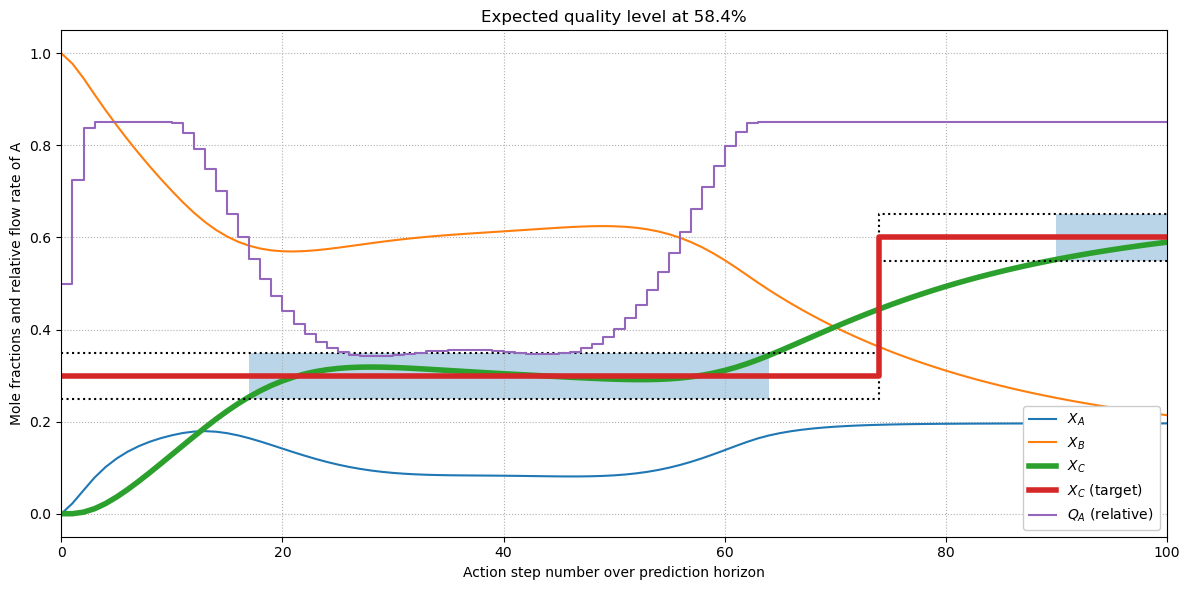

In [28]:
steps = list(range(Np+1))
quality = 100 * sum(good.astype("u8")) / len(good)

plt.style.use("default")
plt.figure(figsize=(12, 6))
plt.grid(linestyle=":")
plt.plot(steps, xt_A, label="$X_A$")
plt.plot(steps, xt_B, label="$X_B$")
plt.plot(steps, xt_C, lw=4, label="$X_C$")
plt.step(steps, xs_C_max, "k:", label="_none_")
plt.step(steps, xs_C_min, "k:", label="_none_")
plt.step(steps, xs_C_num, lw=4, label="$X_C$ (target)")
plt.step(steps, qdot_A_opt / qdot_t, label="$Q_A$ (relative)", where="post")
plt.fill_between(steps, xs_C_min, xs_C_max, where=good, alpha=0.3)
plt.title(f"Expected quality level at {quality:.1f}%")
plt.ylabel("Mole fractions and relative flow rate of A")
plt.xlabel("Action step number over prediction horizon")
plt.legend(loc=4, fancybox=True,  framealpha=1.0)
plt.xlim(0, Np)
plt.tight_layout()

There are many ways you could propose exercises from this guided study:
- Implement a higher order time-stepping scheme.
- Provide simultaneous simulation/optimization with multiple-shooting.
- Investigate role of total flow rate or reactor size over quality.
- Use the solver in a simulated control loop with random noise in measurements.
- ...